# Deep learning-based automated rock classification via high-resolution drone-captured core sample imagery
***
### Domenico M. Crisafulli, Misael M. Morales, and Carlos Torres-Verdin
#### The University of Texas at Austin, 2024
***

## Build and Train NN-classifier
| Class             | OLD   | New   |
| ---               | ---   | ---   |
| Background        | 0     | 0     |
| Sandstone type 1  | 1     | 2     |
| Shaly Rock        | 2     | 3     |
| Sandstone type 2  | 3     | 4     |
| Carbonate         | 4     | 5     |
| Shale             | 5     | 6     |
| Sandstone type 3  | 6     | 7     |
| Box               | 10    | 1     |

In [76]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tf_keras as tfk
from keras import Model
from keras_cv.losses import FocalLoss
from keras import layers, losses, metrics, optimizers, activations, callbacks

def check_tf_gpu(verbose:bool=True):
    sys_info = tf.sysconfig.get_build_info()
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    if verbose:
        print('-'*60)
        print('----------------------- VERSION INFO -----------------------')
        print('TF version: {} | # Device(s) available: {}'.format(version, count))
        print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
        print(tf.config.list_physical_devices()[0],'\n', tf.config.list_physical_devices()[1])
        print('-'*60+'\n')
    return None

check_tf_gpu()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TF version: 2.17.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.3 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------



In [3]:
def patch_image(input_image, patch_h=252, patch_w=252, pad=4, channel_axis=-1):
    if channel_axis is not None:
        h, w, c = input_image.shape
    else:
        h, w = input_image.shape
    patches = []
    for i in range(0, h, patch_h):
        for j in range(0, w, patch_w):
            if channel_axis is not None:
                patch = input_image[i:i+patch_h, j:j+patch_w, :]
                patch = np.pad(patch, ((pad,pad),(pad,pad),(0,0)))
            else:
                patch = input_image[i:i+patch_h, j:j+patch_w]
                patch = np.pad(patch, ((pad,pad),(pad,pad)))
            patches.append(patch)
    return np.array(patches)

In [4]:
x_names_pictures = []
for root, dirs, files in os.walk('data'):
    for f in files:
        if (f.endswith('.jpg') or f.endswith('.JPG')) and f.startswith('DJI'):
            x_names_pictures.append(os.path.join(root, f))

y_names_masks = []
for root, dirs, files in os.walk('data'):
    for file in files:
        if file.endswith('.mat') and file.startswith('img_'):
            y_names_masks.append(os.path.join(root, file))

In [5]:
x_pictures = []
y_masks    = []
for i in tqdm(range(len(x_names_pictures)), desc='Loading images'):
    y = sio.loadmat(y_names_masks[i],simplify_cells=True)
    if 'AA' in y.keys():
        y_masks.append(y['AA'])
        x = np.array(Image.open(x_names_pictures[i]).convert('RGB'))
        x_pictures.append(x)

X_data = np.array(x_pictures)
y_data = np.array(y_masks)
print(X_data.shape, y_data.shape)

Loading images: 100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


(15, 3024, 4032, 3) (15, 3024, 4032)


In [6]:
IMAGE_SIZE = 504
PADDING = 4
PADDED_IMAGE = IMAGE_SIZE+PADDING*2

x_data_patched = []
y_data_patched = []
for i in tqdm(range(X_data.shape[0]), desc='Patching images'):
    x = patch_image(X_data[i], patch_h=IMAGE_SIZE, patch_w=IMAGE_SIZE, pad=PADDING)
    x_data_patched.append(x)
    y = patch_image(y_data[i], patch_h=IMAGE_SIZE, patch_w=IMAGE_SIZE, pad=PADDING, channel_axis=None)
    y_data_patched.append(y)
    
x_data_patched = np.array(x_data_patched).reshape(-1, PADDED_IMAGE, PADDED_IMAGE, 3)
y_data_patched = np.array(y_data_patched).reshape(-1, PADDED_IMAGE, PADDED_IMAGE, 1)
print(x_data_patched.shape, y_data_patched.shape)

Patching images: 100%|██████████| 15/15 [00:00<00:00, 59.30it/s]


(720, 512, 512, 3) (720, 512, 512, 1)


In [15]:
idx = []
percent_nonzero = 0.05

for i in tqdm(range(y_data_patched.shape[0]), desc='Nonzero Filter'):
    m = y_data_patched[i]
    p = np.sum(m)
    if p > int(0.10 * IMAGE_SIZE**2):
        idx.append(i)

x_data_nonzero = x_data_patched[idx].astype(np.float32)
y_data_nonzero = y_data_patched[idx].astype(np.uint8)
print(x_data_nonzero.shape, y_data_nonzero.shape)

Nonzero Filter: 100%|██████████| 720/720 [00:00<00:00, 9545.80it/s]


(267, 512, 512, 3) (267, 512, 512, 1)


In [16]:
rand_idx = np.random.choice(x_data_nonzero.shape[0], size=x_data_nonzero.shape[0], replace=False)
n_train = 250

X_train = x_data_nonzero[rand_idx[:n_train]]/255
y_train = y_data_nonzero[rand_idx[:n_train]]

X_test = x_data_nonzero[rand_idx[n_train:]]/255
y_test = y_data_nonzero[rand_idx[n_train:]]

y_train[y_train==255] = 5
y_test[y_test==255] = 5

print('Train - X: {} | y: {} | Labels: {}'.format(X_train.shape, y_train.shape, np.unique(y_train)))
print('Test  - X: {} | y: {} | Labels: {}'.format(X_test.shape, y_test.shape, np.unique(y_test)))

X - train: (250, 512, 512, 3) | test: (17, 512, 512, 3)
y - train: (250, 512, 512, 1) | test: (17, 512, 512, 1)
Labels - train: [0 1 2 3 4 5 6] | test: [0 1 2 3 4 5 6]


In [17]:
nlabels = len(np.unique(y_train))

y_train_masked = np.zeros((y_train.shape[0], 512, 512, nlabels))
y_test_masked  = np.zeros((y_test.shape[0], 512, 512, nlabels))

for i in tqdm(range(nlabels), desc='One-Hot Encoding labels'):
    y_train_masked[...,i] = (y_train[...,0]==i).astype(np.uint8)
    y_test_masked[...,i]  = (y_test[...,0]==i).astype(np.uint8)
print('y masked - train: {} | test: {}'.format(y_train_masked.shape, y_test_masked.shape))

One-Hot Encoding labels: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

y masked - train: (250, 512, 512, 7) | test: (17, 512, 512, 7)


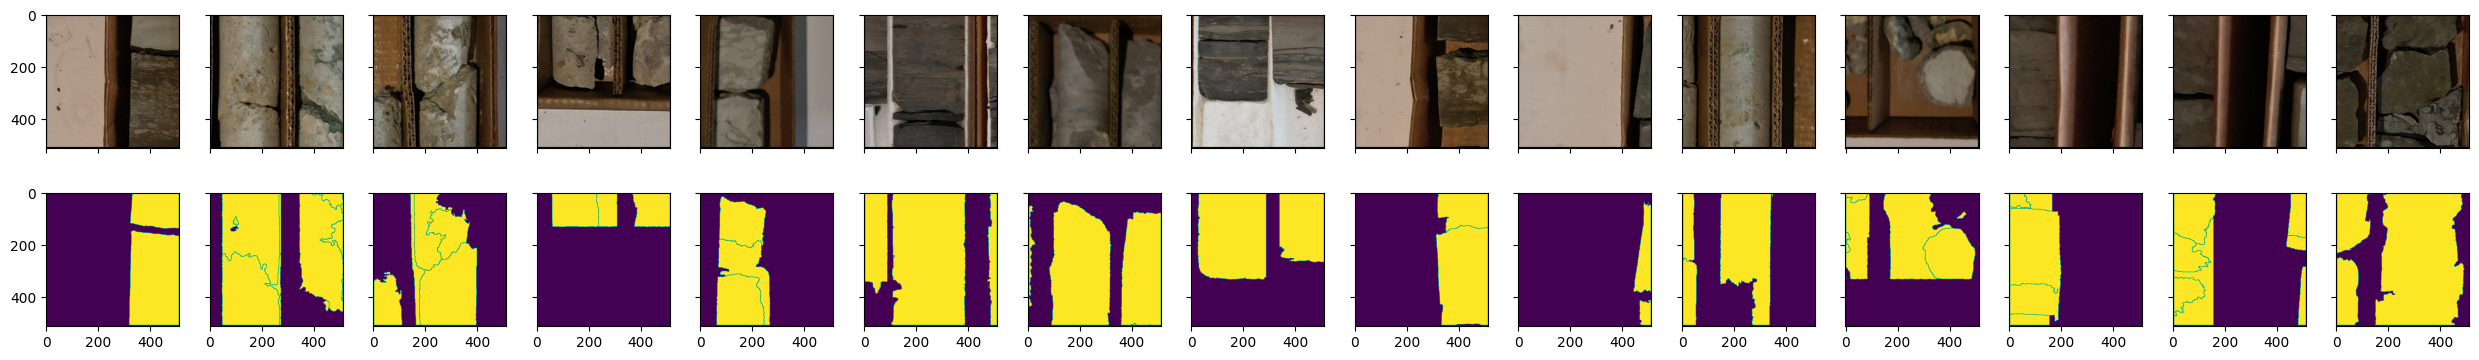

In [18]:
fig, axs = plt.subplots(2, 15, figsize=(25,4), sharex=True, sharey=True)
for j in range(15):
    ax1, ax2 = axs[0,j], axs[1,j]
    ax1.imshow(X_train[j])
    ax2.imshow(y_train[j])
plt.tight_layout()
plt.show()

In [20]:
def CoreSegNet(image_size:int=512, in_channels:int=3, out_channels:int=1, hidden:{list,tuple}=(16,64,256)):
    
    def convolution_block(inp, num_filters, kernel_size=3, dropout=0.1):
        _ = layers.SeparableConv2D(num_filters, kernel_size=kernel_size, padding="same")(inp)
        _ = layers.GroupNormalization(num_filters)(_)
        _ = activations.gelu(_)
        _ = layers.SpatialDropout2D(dropout)(_)
        return _
    
    # Encoder
    input = layers.Input(shape=(image_size, image_size, in_channels))
    x = convolution_block(input, hidden[0])
    x = layers.MaxPooling2D(2)(x)
    f1 = x
    x = convolution_block(x, hidden[1])
    x = layers.MaxPooling2D(2)(x)
    f2 = x
    x = convolution_block(x, hidden)
    x = layers.MaxPooling2D(2)(x)
    f3 = x
    
    # Decoder
    x = layers.concatenate([x, f3])
    x = convolution_block(x, hidden[2])
    x = layers.Conv2DTranspose(hidden[1], kernel_size=2, strides=2, padding='same')(x)

    x = layers.concatenate([x, f2])
    x = convolution_block(x, hidden[1])
    x = layers.Conv2DTranspose(hidden[0], kernel_size=2, strides=2, padding='same')(x)

    x = layers.concatenate([x, f1])
    x = convolution_block(x, hidden[0])
    x = layers.Conv2DTranspose(out_channels, kernel_size=2, strides=2, padding='same')(x)

    output = layers.Conv2D(out_channels, kernel_size=1, strides=1, activation='softmax')(x)
    
    return Model(inputs=input, outputs=output)

In [154]:
class CustomLoss(losses.Loss):
    def __init__(self, segmentation_weight=0.80, perceptual_weight=0.10, alpha=0.50, beta=0.50, gamma=0.50):
        super(CustomLoss, self).__init__()
        '''
        alpha: controls the weight of categorical cross-entropy (vs. focal)
        beta:  controls the weight of mse (vs. mae)
        gamma: controls the weight of ssim (vs. psnr)
        '''
        self.a     = segmentation_weight
        self.b     = perceptual_weight if segmentation_weight != 1 else 0
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma
        self.focal = FocalLoss()

    def call(self, true, pred):
        cce = losses.categorical_crossentropy(true, pred)
        foc = self.focal(true, pred)
        segmentation = self.alpha * cce + (1-self.alpha) * foc

        mse = tf.reduce_mean(tf.square(true - pred))
        mae = tf.reduce_mean(tf.abs(true - pred))
        reconstruction = self.beta * mse + (1-self.beta) * mae

        true_ = (true - keras.ops.min(true)) / (keras.ops.max(true) - keras.ops.min(true))
        pred_ = (pred - keras.ops.min(pred)) / (keras.ops.max(pred) - keras.ops.min(pred))
        ssim = 1 - tf.reduce_mean(tf.image.ssim(true_, pred_, max_val=1.0))
        psnr = 1 / tf.reduce_mean(tf.image.psnr(true_, pred_, max_val=1.0))
        perceptual = self.gamma * ssim + (1-self.gamma) * psnr

        return (self.a * segmentation) + (self.b * perceptual) + ((1-self.a-self.b) * reconstruction)

In [155]:
class MonitorCallback(keras.callbacks.Callback):
    def __init__(self, monitor:int=10):
        super(MonitorCallback, self).__init__()
        self.monitor = monitor
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.monitor == 0:
            print('Epoch: {} | Accuracy: {:.3f} | Loss: {:.3e}'.format(epoch+1, logs['accuracy'], logs['loss']))

In [77]:
model = CoreSegNet(image_size=512, out_channels=nlabels)
print('# parameters: {:,}'.format(model.count_params())+'\n'+'-'*30)

optimizer = optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
#criterion = losses.CategoricalCrossentropy()
criterion = CustomLoss(segmentation_weight=1)
metricIOU = metrics.OneHotMeanIoU(num_classes=nlabels)
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy',metricIOU,'mse'])

esCallback = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
mcCallback = callbacks.ModelCheckpoint('CoreSegNet.keras', monitor='val_accuracy', save_best_only=True)
CustomCBs  = [MonitorCallback(monitor=10), esCallback, mcCallback]

start = time()
fit = model.fit(X_train, y_train_masked,
                batch_size       = 8, 
                epochs           = 301, 
                validation_split = 0.2,
                shuffle          = True,
                verbose          = 0,
                callbacks        = [CustomCBs])
print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
model.save('CoreSegNet.keras')
pd.DataFrame(fit.history).to_csv('CoreSegNet_history.csv', index=False)

# parameters: 236,266
------------------------------
Epoch: 10 | Accuracy: 0.610 | Loss: 5.582e-01
Epoch: 20 | Accuracy: 0.636 | Loss: 4.878e-01
Epoch: 30 | Accuracy: 0.667 | Loss: 4.424e-01
Epoch: 40 | Accuracy: 0.713 | Loss: 4.212e-01
Epoch: 50 | Accuracy: 0.735 | Loss: 3.884e-01
Epoch: 60 | Accuracy: 0.784 | Loss: 3.576e-01
Epoch: 70 | Accuracy: 0.789 | Loss: 3.383e-01
Epoch: 80 | Accuracy: 0.815 | Loss: 3.030e-01
Epoch: 90 | Accuracy: 0.811 | Loss: 2.920e-01
Epoch: 100 | Accuracy: 0.826 | Loss: 2.762e-01
Epoch: 110 | Accuracy: 0.828 | Loss: 2.639e-01
Epoch: 120 | Accuracy: 0.855 | Loss: 2.398e-01
Epoch: 130 | Accuracy: 0.859 | Loss: 2.252e-01
Epoch: 140 | Accuracy: 0.864 | Loss: 2.196e-01
Epoch: 150 | Accuracy: 0.858 | Loss: 2.251e-01
Epoch: 160 | Accuracy: 0.874 | Loss: 1.970e-01
------------------------------
Training time: 7.99 minutes


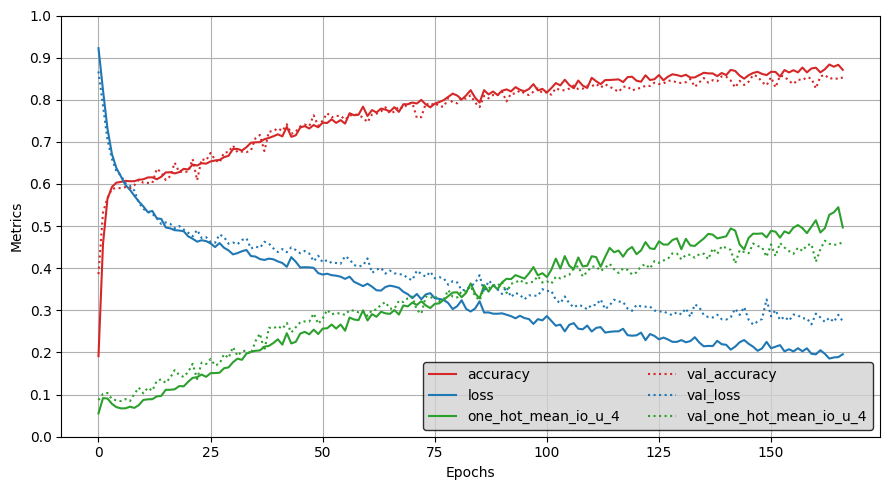

In [153]:
hues = ['tab:red','tab:blue','k','tab:green', 'tab:red','tab:blue','k','tab:green']
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
for i, k in enumerate(fit.history.keys()):
    ax.plot(fit.history[k], color=hues[i], label=k, ls=':' if (i)//4!=0 else None) if (i+2)%4!=0 else None
ax.legend(ncols=2, edgecolor='k', facecolor='lightgrey', loc='lower right')
ax.grid(True, which='both')
ax.set(xlabel='Epochs', ylabel='Metrics', ylim=(0,1), yticks=np.arange(0,1.1,0.1))
plt.tight_layout()
plt.show()

In [72]:
y_train_pred = model.predict(X_train[:15], verbose=0)
y_test_pred  = model.predict(X_test[:15], verbose=0)
print('Pred - train: {} | test: {}'.format(y_train_pred.shape, y_test_pred.shape))

Pred - train: (15, 512, 512, 7) | test: (15, 512, 512, 7)


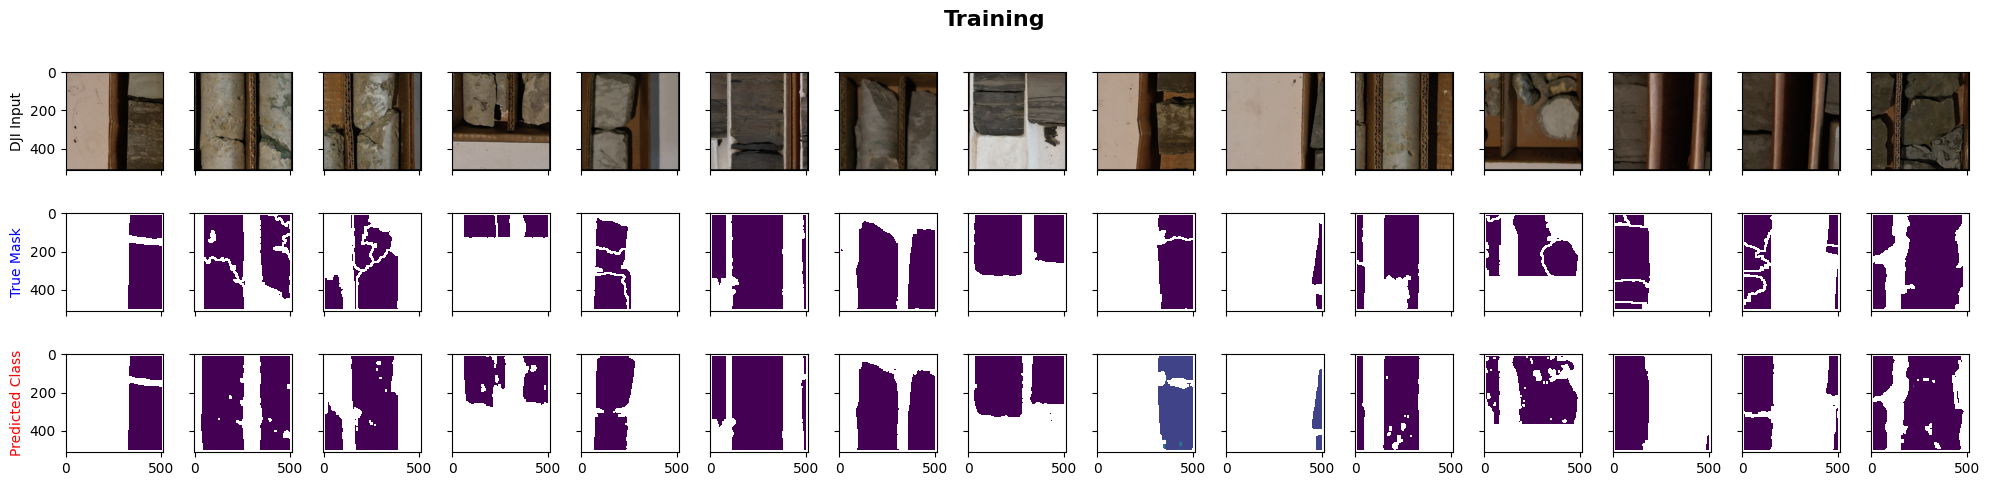

In [73]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
fig, axs = plt.subplots(3, 15, figsize=(20,5), sharex=True, sharey=True)

for j in range(15):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_train[j])

    true = y_train_masked[j].argmax(-1)
    pred = y_train_pred[j].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt)
    ax3.imshow(dp)

    [a.set_ylabel(labels[k], color=colors[k]) for k,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Training', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('figures/true_pred_train.png', dpi=600)
plt.show()

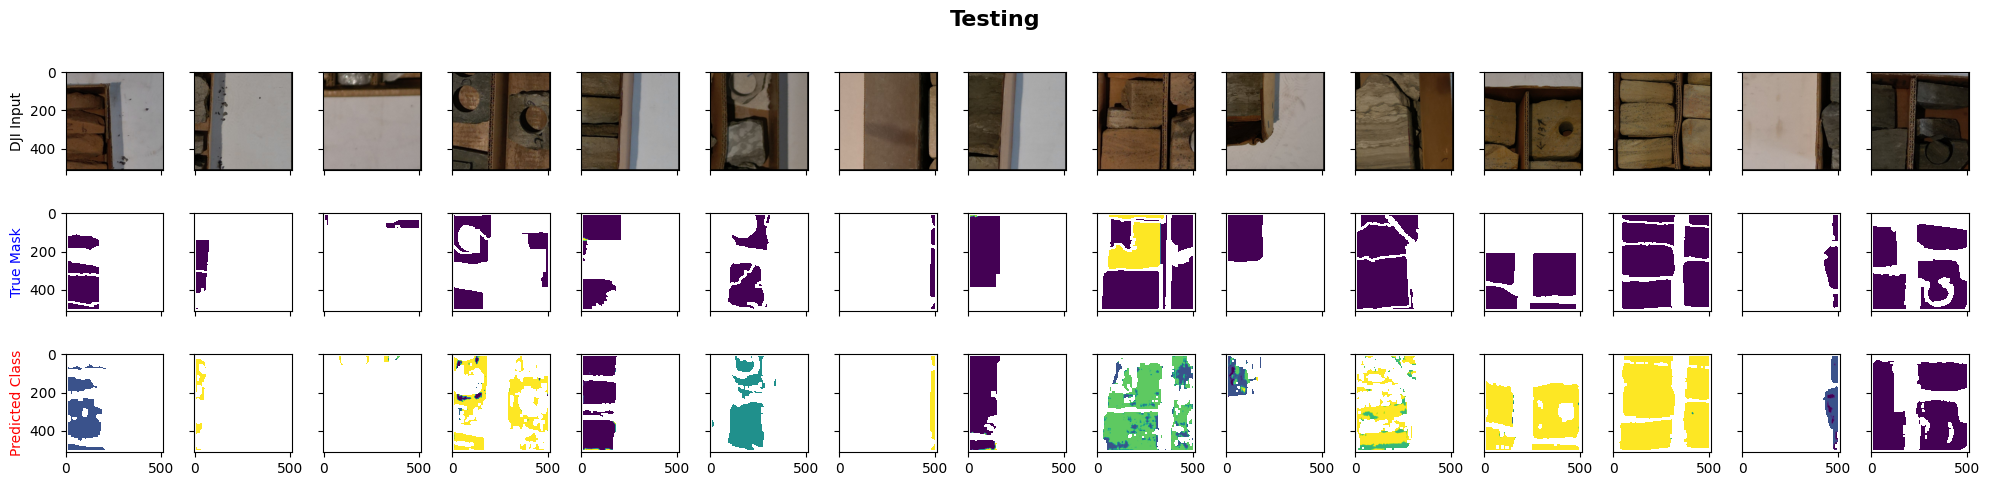

In [74]:
labels = ['DJI Input', 'True Mask', 'Predicted Class']
colors = ['black','blue','red']
fig, axs = plt.subplots(3, 15, figsize=(20,5), sharex=True, sharey=True)

for j in range(15):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    ax1.imshow(X_test[j])

    true = y_test_masked[j].argmax(-1)
    pred = y_test_pred[j].argmax(-1)

    dt = np.ma.masked_where(true==0, true)
    dp = np.ma.masked_where(pred==0, pred)

    ax2.imshow(dt)
    ax3.imshow(dp)

    [a.set_ylabel(labels[k], color=colors[k]) for k,a in enumerate([ax1,ax2,ax3])] if j==0 else None

fig.suptitle('Testing', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('figures/true_pred_test.png', dpi=600)
plt.show()

***
# END